In [1]:
!pip install scikit-image nibabel monai onnxruntime


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Testing the Model Deployment

After deploying the model using RHOAI Model Serving, we'd like to test the model deployment by sending images to the model server for real-time inference.

In this notebook we'll review how to consume the model through the RHOAI Model Server.

We'll start by importing the preprocessing and rendering functions that we have worked with in the previous notebook.

In [2]:
import numpy as np
from time import sleep

import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from requests import post
from skimage.transform import resize
import torch

Let's prepare one of our sample images as a test sample.

In [3]:
prediction_url = 'https://spleen-v7-spleen.apps.rhods-internal.61tk.p1.openshiftapps.com/v2/models/spleen-v7/infer'

In [4]:
def serialize(image):
    payload = {
        'inputs': [
            {
                'name': 'x',
                'shape': [1, 1, 96, 96, 96],
                'datatype': 'FP32',
                'data': image,
            }
        ]
    }
    return payload

Let's now send the serialized image to the model server. The inference results will also be returned in a generic JSON structure, which we can unpack straightaway. We'll also apply the post-processing function we defined in the previous notebook to extract the familiar object properties.

In [5]:
def get_model_response(payload, prediction_url):
    raw_response = post(prediction_url, json=payload)
    try:
        response = raw_response.json()
    except:
        print(f'Failed to deserialize service response.\n'
              f'Status code: {raw_response.status_code}\n')
        #      f'Response body: {raw_response.text}')
    try:
        model_output = response['outputs']
    except:
        print(f'Failed to extract model output from service response.\n')
#              f'Service response: {response}')
    return model_output

Let's now visualize the result as in the previous notebook.

In [6]:
roi_size = (96, 96, 96)
sw_batch_size = 1  # TODO: use larger batch size, e.g. 4

In [7]:
device = torch.device('cuda:0')

In [8]:
roi_size, sw_batch_size

((96, 96, 96), 1)

In [9]:
mydata = torch.tensor([[np.load("image_0.npy")]]).to(device)

/tmp/ipykernel_249114/2948773172.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  mydata = torch.tensor([[np.load("image_0.npy")]]).to(device)


In [10]:
def deserialize(model_response):
    response_data = model_response[0] if model_response else None

    if response_data is not None:
        # Extract relevant information from the response
        shape = response_data.get('shape')
        data = response_data.get('data')

        if shape is not None and data is not None:
            # Convert the data to a NumPy array
            inferred_data_np = np.array(data)

            # Check the shape of the inferred data
            print("Shape of inferred_data_np:", inferred_data_np.shape)

            # Reshape the inferred data to the appropriate shape for a 3D volume
            desired_shape = tuple(shape)
            volume_size = np.prod(desired_shape)

            if inferred_data_np.size == volume_size:
                inferred_data_reshaped = inferred_data_np.reshape(desired_shape)

                # Check the shape after reshaping
                print("Shape after reshaping:", inferred_data_reshaped.shape)
                return torch.tensor(inferred_data_reshaped).to(device)
            else:
                print("Error: Size of inferred data does not match the volume size.")
        else:
            print("Error: Required information (shape or data) missing in the response.")
    else:
        print("Error: No data in the response.")

def badass_function(input_data):
    print(f'input shape: {input_data.size()}')
    #  output_data = torch_model(input_data)
    flattened = input_data.flatten().tolist()
    payload = serialize(flattened)
    response = get_model_response(payload, prediction_url)
    output_data = deserialize(response)
    print(f'output shape: {output_data.size()}')
    return output_data


In [15]:
import json
import torch

# Convert PyTorch tensor to NumPy array
numpy_array = output_data.detach().cpu().numpy()

# Convert NumPy array to Python list
data_list = numpy_array.tolist()

# Convert Python list to JSON string
json_str = json.dumps(data_list)

# Define the filename for the JSON file
json_filename = "input_data.json"

# Write the JSON string to a file
with open(json_filename, "w") as json_file:
    json_file.write(json_str)

print(f"JSON file '{json_filename}' has been created.")


JSON file 'input_data.json' has been created.


In [12]:
sliding_output = sliding_window_inference(mydata, roi_size, sw_batch_size, badass_function)
sliding_output = sliding_output.detach().cpu()

input shape: torch.Size([1, 1, 96, 96, 96])
Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
output shape: torch.Size([1, 2, 96, 96, 96])
input shape: torch.Size([1, 1, 96, 96, 96])
Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
output shape: torch.Size([1, 2, 96, 96, 96])
input shape: torch.Size([1, 1, 96, 96, 96])
Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
output shape: torch.Size([1, 2, 96, 96, 96])
input shape: torch.Size([1, 1, 96, 96, 96])
Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
output shape: torch.Size([1, 2, 96, 96, 96])
input shape: torch.Size([1, 1, 96, 96, 96])
Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
output shape: torch.Size([1, 2, 96, 96, 96])
input shape: torch.Size([1, 1, 96, 96, 96])
Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
output shape: torch.Size([1, 2,

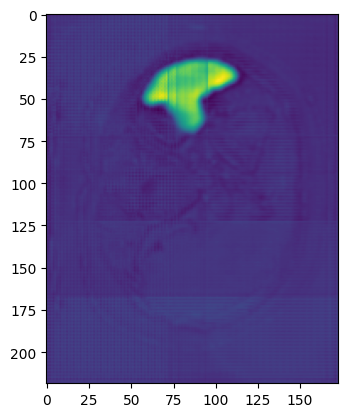

In [13]:
plt.imshow(sliding_output[0][1][:, :, 50])